In [1]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 50000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)


human sounds ['yeo', 'uye', 'eyu', 'oey', 'eou', 'iuo']


In [2]:
n_goals = 10000

eval_results = {}

for region in [1, 2, 3]:  
    print region
    eval_results[region] = {}
    for i in range(n_goals):
        eval_results[region][i] = {}
        environment.reset_toys(region=region)
        for toy in ["toy1", "toy2", "toy3"]:
            eval_results[region][i][toy] = {}
            if toy == "toy1":
                goal = [environment.current_toy1[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy1[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
            elif toy == "toy2":
                goal = [environment.current_toy2[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy2[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
            elif toy == "toy3":
                goal = [environment.current_toy3[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy3[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                    
            m = agent.motor_babbling()
            s = environment.update(m)
            reached = s[30:40]
            comp_error = np.linalg.norm(np.array(reached) - np.array(goal))
            eval_results[region][i][toy]["comp_error"] = comp_error
            eval_results[region][i][toy]["toy_pos"] = [goal[0], goal[5]]
            


1


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


best_vocal_errors [('yeo', 0.76033316294090836), ('uye', 0.88383493448180783), ('eyu', 0.87405343044720829), ('oey', 0.54692437619889778), ('eou', 0.81914475729311831), ('iuo', 1.0335692963292531)]
best_vocal_errors [('yeo', 0.76033316294090836), ('uye', 0.78635702466134982), ('eyu', 0.87405343044720829), ('oey', 0.54692437619889778), ('eou', 0.81914475729311831), ('iuo', 0.64481659647636347)]
best_vocal_errors [('yeo', 0.76033316294090836), ('uye', 0.78635702466134982), ('eyu', 0.69198538434256363), ('oey', 0.54692437619889778), ('eou', 0.81914475729311831), ('iuo', 0.64481659647636347)]
best_vocal_errors [('yeo', 0.65365581679999407), ('uye', 0.78635702466134982), ('eyu', 0.69198538434256363), ('oey', 0.54692437619889778), ('eou', 0.81914475729311831), ('iuo', 0.64481659647636347)]
best_vocal_errors [('yeo', 0.64975621907999526), ('uye', 0.78635702466134982), ('eyu', 0.69198538434256363), ('oey', 0.54692437619889778), ('eou', 0.67246475417993679), ('iuo', 0.64481659647636347)]
best_v

NameError: name 'map_comp' is not defined

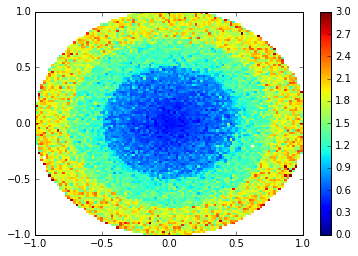

In [11]:
bins = 100
map_comp = np.zeros((bins, bins))
map_count = np.zeros((bins, bins))

min_2d = [-1.,  -1.]
max_2d = [1.,  1.]

def real2map(x, y):
    i = int((x - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    j = int((y - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    i = max(0, min(i, 99))
    j = max(0, min(j, 99))
    return i, j

for region in [1, 2, 3]:
    for gi in range(n_goals):
        for toy in ["toy1", "toy2", "toy3"]:
            x, y = eval_results[region][gi][toy]["toy_pos"]
            i, j = real2map(x, y)
            map_comp[i, j] += eval_results[region][gi][toy]["comp_error"]
            map_count[i, j] += 1
        
for i in range(bins):
    for j in range(bins):
        n = map_count[i, j]
        if n > 0:
            map_comp[i, j] /= n
        else:
            map_comp[i, j] = -1
            

x_points = np.linspace(-1., 1., bins)
y_points = np.linspace(-1., 1., bins)

pcol = plt.pcolormesh(x_points, y_points, map_comp, vmin=0, vmax=3., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

In [12]:

map_comp_mb_avg = np.zeros((bins, bins))

# AVERAGE MOTOR BABBLING ERROR MAP
for i in range(bins):
    for j in range(bins):
        d = np.sqrt((i-bins/2)*(i-bins/2) + (j-bins/2)*(j-bins/2))
        idx_similar = [[k, l] for k in range(bins) for l in range(bins) if d - 1 < np.sqrt((k-bins/2)*(k-bins/2) + (l-bins/2)*(l-bins/2)) < d + 1]        
        map_comp_mb_avg[i, j] = np.mean([map_comp[idx[0], idx[1]] for idx in idx_similar if map_comp[idx[0], idx[1]] > 0.])
        
map_comp_mb_avg

/home/sforesti/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/sforesti/.local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [13]:
import cPickle

log_dir = "/home/sforesti/avakas/scratch/sforestier001/logs/CogSci2017/2017-01-17_19-32-17-EXPLO-0.5"
filename = log_dir + '/results/motor_babbling.pickle'
with open(filename, 'wb') as f:
    cPickle.dump(map_comp_mb_avg, f)
f.close()


filename = '../data/motor_babbling.pickle'
with open(filename, 'wb') as f:
    cPickle.dump(map_comp_mb_avg, f)
f.close()